# LSTM for Delay Prediction

Testing whether an LSTM can match the tree-based results. Uses 22 features per timestep with 28-day input sequences. No explicit lag columns since the target history is already in the sequence, and no route encoding since treating categorical IDs as numeric creates fake ordinality.

In [1]:
# imports
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from src.models.lstm import FlightDelayLSTM, LSTMTrainer
from src.evaluation.metrics import calculate_delay_metrics
from src.config import TRAIN_END, VAL_END, TEST_START
from src.config import SEQUENCE_MODEL_FEATURES

TARGET_COL = 'avg_arr_delay'
device = torch.device('mps')
print(f'Using device: {device}')

Importing plotly failed. Interactive plots will not work.


Using device: mps


## Load and Prepare Data

In [2]:
# load feature data
df = pd.read_csv('../data/processed/features.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['route', 'date']).reset_index(drop=True)

print(f'Total samples: {len(df):,}')

Total samples: 47,460


In [3]:
# filter to available features in dataset
available_features = [c for c in SEQUENCE_MODEL_FEATURES if c in df.columns]
print(f'Using {len(available_features)} features for LSTM (minimal time-native set)')
print(f'Features: {available_features}')

Using 22 features for LSTM (minimal time-native set)
Features: ['avg_arr_delay', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_federal_holiday', 'is_holiday_week', 'is_school_break', 'is_covid_period', 'is_covid_recovery', 'is_post_covid', 'weather_severity_max', 'apt1_severity', 'apt2_severity', 'has_adverse_weather', 'apt1_temp_avg', 'apt2_temp_avg', 'total_precip', 'total_snowfall', 'max_wind', 'severe_weather_level']


## Create Data Loaders

In [4]:
# create train/val/test splits and data loaders
config = {
    'sequence_length': 28,
    'batch_size': 32,
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0.3,
    'learning_rate': 0.001,
    'epochs': 50,
}

train_df = df[df['date'] < TRAIN_END].copy()
val_df = df[(df['date'] >= TRAIN_END) & (df['date'] < VAL_END)].copy()
test_df = df[df['date'] >= TEST_START].copy()

print(f'Train: {len(train_df):,} ({train_df["date"].min().date()} to {train_df["date"].max().date()})')
print(f'Val:   {len(val_df):,} ({val_df["date"].min().date()} to {val_df["date"].max().date()})')
print(f'Test:  {len(test_df):,} ({test_df["date"].min().date()} to {test_df["date"].max().date()})')

scaler = StandardScaler()
scaler.fit(train_df[available_features].values)

def create_route_sequences(route_df, scaler, feature_cols, target_col, seq_len):
    """Create sequences per route for proper time series handling."""
    all_X, all_y = [], []
    for route in route_df['route'].unique():
        rdf = route_df[route_df['route'] == route].sort_values('date')
        features = scaler.transform(rdf[feature_cols].values)
        targets = rdf[target_col].values
        for i in range(seq_len, len(rdf)):
            all_X.append(features[i-seq_len:i])
            all_y.append(targets[i])
    return np.array(all_X), np.array(all_y)

train_X, train_y = create_route_sequences(train_df, scaler, available_features, TARGET_COL, config['sequence_length'])
val_X, val_y = create_route_sequences(val_df, scaler, available_features, TARGET_COL, config['sequence_length'])
test_X, test_y = create_route_sequences(test_df, scaler, available_features, TARGET_COL, config['sequence_length'])

print(f'\nSequences: Train={len(train_X):,}, Val={len(val_X):,}, Test={len(test_X):,}')

train_dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])

print(f'Batches: Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}')

Train: 36,520 (2019-01-01 to 2023-12-31)
Val:   3,640 (2024-01-01 to 2024-06-30)
Test:  7,300 (2024-07-01 to 2025-06-30)

Sequences: Train=35,960, Val=3,080, Test=6,740
Batches: Train=1124, Val=97, Test=211


#### Hyperparameter notes:
- **28-day sequences**: captures weekly cycles from EDA
- **Hidden size 64**: reasonable for ~36,000 training sequences
- **2 LSTM layers**: hierarchical patterns without overfit risk
- **Dropout 0.3**: regularization for limited data
- **LR 0.001**: standard Adam starting point, swept below

## Load Trained Model

Model is trained via `src/training/train_lstm.py` and saved to `trained_models/`. Loading the checkpoint here for evaluation and analysis.

In [5]:
# load trained LSTM from checkpoint
checkpoint = torch.load('../trained_models/best_lstm_arr_delay.pt', map_location=device, weights_only=False)

model = FlightDelayLSTM(
    input_size=checkpoint['input_size'],
    hidden_size=checkpoint['hidden_size'],
    num_layers=checkpoint['num_layers'],
    dropout=checkpoint['dropout']
)
model.load_state_dict(checkpoint['model_state_dict'])

trainer = LSTMTrainer(model, learning_rate=config['learning_rate'], device=device)
history = checkpoint['history']

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Trained for {len(history["train_loss"])} epochs')

Total parameters: 60,034
Trainable parameters: 60,034
Trained for 20 epochs


## Training Curves

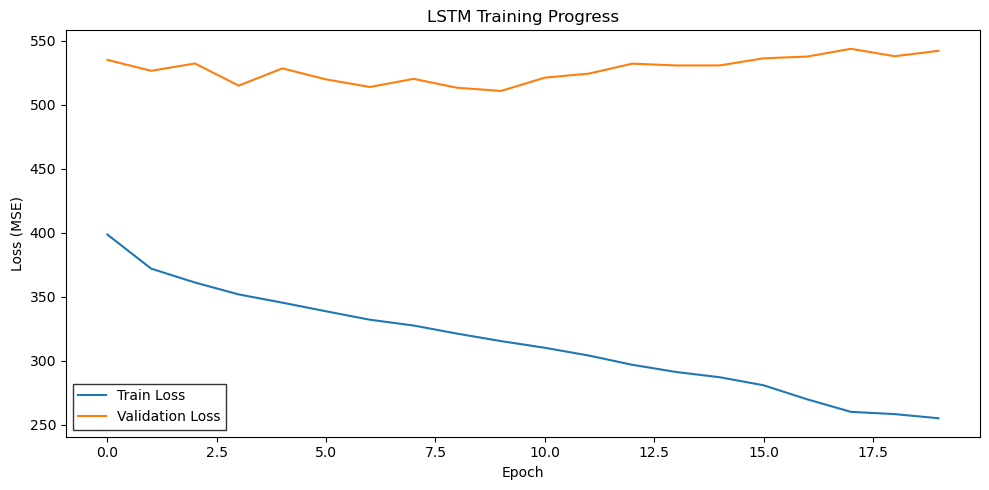

In [6]:
# plot training and validation loss curves
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(history['train_loss'], label='Train Loss')
ax.plot(history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('LSTM Training Progress')
ax.legend(frameon=True, edgecolor='black')

plt.tight_layout()
plt.show()

### Train/Val Gap

The widening gap looks like overfitting. The model learns training patterns that don't fully transfer to 2024. Likely causes:

- **Distribution shift**: training spans 2019-2023 including COVID, validation is 2024
- **No route identity**: one global model for 20 routes with different delay profiles
- **Feature set**: the LSTM discovers patterns that XGBoost gets explicitly through lag features. I tried the full 57-feature set too, but it didn't help since the lag columns duplicate what's already in the sequence

Early stopping prevents this from getting worse and worse.

## Evaluate on Test Set

In [ ]:
# evaluate model on test set
predictions = trainer.predict(test_loader)

test_targets = []
for _, y in test_loader:
    test_targets.extend(y.numpy())
test_targets = np.array(test_targets)

metrics = calculate_delay_metrics(test_targets, predictions)

print('\nTest Set Metrics (Delay Prediction):')
print(f'  MAE:              {metrics["mae"]:.2f} min')
print(f'  RMSE:             {metrics["rmse"]:.2f} min')
print(f'  Within 15min:     {metrics["within_15"]:.1f}%')
print(f'  Directional Acc:  {metrics["directional"]:.1f}%')
print(f'  R²:               {metrics["r2"]:.3f}')

## Baseline Comparison

In [8]:
# compare against naive and rolling baselines
naive_preds = test_df.groupby('route').apply(
    lambda x: x[TARGET_COL].shift(1)
).droplevel(0).dropna()

naive_targets = test_df.loc[naive_preds.index, TARGET_COL]
naive_metrics = calculate_delay_metrics(naive_targets.values, naive_preds.values)

rolling_preds = test_df.groupby('route').apply(
    lambda x: x[TARGET_COL].shift(1).rolling(7, min_periods=1).mean()
).droplevel(0).dropna()

rolling_targets = test_df.loc[rolling_preds.index, TARGET_COL]
rolling_metrics = calculate_delay_metrics(rolling_targets.values, rolling_preds.values)

print('Baseline Comparison:')
print(f'  Naive (last value):     MAE={naive_metrics["mae"]:.2f}, RMSE={naive_metrics["rmse"]:.2f}, R²={naive_metrics["r2"]:.3f}')
print(f'  Rolling Mean (7-day):   MAE={rolling_metrics["mae"]:.2f}, RMSE={rolling_metrics["rmse"]:.2f}, R²={rolling_metrics["r2"]:.3f}')
print(f'  LSTM:                   MAE={metrics["mae"]:.2f}, RMSE={metrics["rmse"]:.2f}, R²={metrics["r2"]:.3f}')

lstm_improvement = (naive_metrics['mae'] - metrics['mae']) / naive_metrics['mae'] * 100
print(f'\nLSTM MAE improvement over naive: {lstm_improvement:.1f}%')

Baseline Comparison:
  Naive (last value):     MAE=16.10, RMSE=26.50, R²=-0.157
  Rolling Mean (7-day):   MAE=14.94, RMSE=23.73, R²=0.073
  LSTM:                   MAE=13.96, RMSE=22.52, R²=0.103

LSTM MAE improvement over naive: 13.3%


## Learning Rate Sweep

5 values from 1e-2 to 1e-4.

In [9]:
# test different learning rates
learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
lr_results = []

for lr in learning_rates:
    torch.manual_seed(42)
    np.random.seed(42)
    
    test_model = FlightDelayLSTM(
        input_size=len(available_features),
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    )
    test_trainer = LSTMTrainer(test_model, learning_rate=lr)
    
    test_history = test_trainer.fit(
        train_loader,
        val_loader,
        epochs=20,
        early_stopping_patience=5,
        verbose=False
    )
    
    val_losses = test_history['val_loss']
    best_val_loss = min(val_losses)
    best_epoch = val_losses.index(best_val_loss) + 1
    
    lr_results.append({
        'learning_rate': lr,
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch
    })
    print(f'LR {lr:.0e}: Best Val Loss = {best_val_loss:.2f} at epoch {best_epoch}')

lr_df = pd.DataFrame(lr_results)
best_idx = lr_df['best_val_loss'].idxmin()
best_lr = lr_df.loc[best_idx, 'learning_rate']
print(f'\nBest learning rate: {best_lr:.0e}')

LR 1e-02: Best Val Loss = 505.65 at epoch 5
LR 5e-03: Best Val Loss = 494.39 at epoch 4
LR 1e-03: Best Val Loss = 457.22 at epoch 6
LR 5e-04: Best Val Loss = 463.72 at epoch 9
LR 1e-04: Best Val Loss = 504.74 at epoch 14

Best learning rate: 1e-03


1e-3 works best. Higher rates are less stable, and the lower rates don't converge fast enough.

## Attention Weights

Higher weights mean that timestep matters more for the prediction.

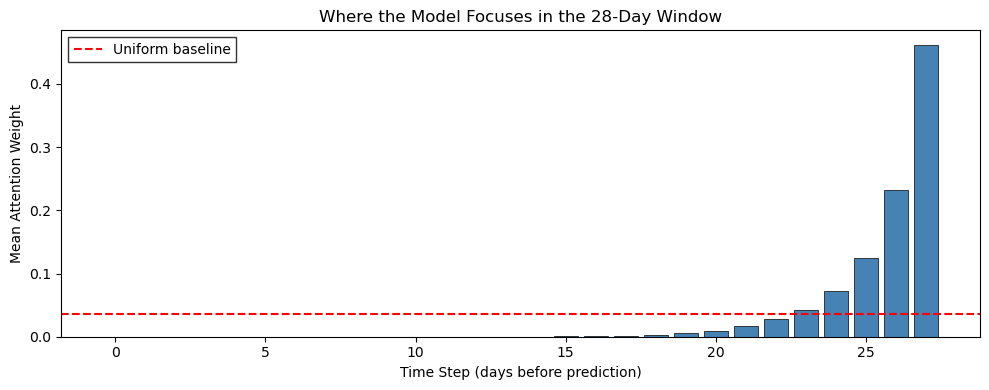

Top 5 attended timesteps: [27, 26, 25, 24, 23] (0=oldest, 27=most recent)


In [10]:
# visualize attention weights across the input sequence
model.eval()
with torch.no_grad():
    sample_batch, _ = next(iter(test_loader))
    sample_batch = sample_batch[:8].to(device)
    attn_weights = model.get_attention_weights(sample_batch)
    attn_np = attn_weights.cpu().numpy()

mean_attn = attn_np.mean(axis=0)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(len(mean_attn)), mean_attn, color='steelblue', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Time Step (days before prediction)')
ax.set_ylabel('Mean Attention Weight')
ax.set_title('Where the Model Focuses in the 28-Day Window')
ax.axhline(y=1/len(mean_attn), color='red', linestyle='--', label='Uniform baseline')
ax.legend(frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()

top_k = 5
top_indices = np.argsort(mean_attn)[-top_k:][::-1]
print(f'Top {top_k} attended timesteps: {list(top_indices)} (0=oldest, {len(mean_attn)-1}=most recent)')

## Summary

The LSTM beats naive by 13.3% MAE but falls short of both tree-based models. The attention weights focus heavily on recent days, which makes sense but also suggests the model is mostly learning a smoothed version of recent history rather than picking up on longer patterns.

I tried the full 57-feature set too, but it didn't help since the lag columns just duplicate what the model already sees in the sequence. The bigger limitations are probably dataset size (~36,000 sequences) and no route identity, both of which the tree-based models handle better through their feature set.

**Next:** [07_tcn_model.ipynb](07_tcn_model.ipynb)